# Case Study 1: New York City Taxi Fare Prediction


![](nyc_taxi_banner.jpg)


The dataset here consists of historical data pertaining to fare amounts (inclusive of tolls) for taxi rides in New York City. There are various attributes here including the fare amount, pickup times, pickup and dropoff co-ordinates and the passenger count! 

The key idea here is if we can build a model on this datset to predict the potential taxi fare for a future taxi ride in NYC given that we know the other attibutes except fare

__Main Objective:__ Given a ride's pickup time, pickup and dropoff coordinates along with the total passengers riding, build a model to predict the fare for a NYC taxi (regression)

_Author: Dipanjan (DJ) Sarkar_

# Load up basic dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

#### Since this is a regression problem, we will use R-square, Adjusted R-square and RMSE to evaluate our models

In [2]:
from sklearn.metrics import r2_score, mean_squared_error

def adjusted_r2_score(y_true, y_pred, X_test):
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    adjusted_r2 = 1 - (1-r2)*(len(y_true)-1)/(len(y_true) - X_test.shape[1]-1)
    return adjusted_r2

# Load and View the Dataset

There are over __50 million__ datapoints in this dataset! We load around __10 million__ datapoints for this case study 

The data is available at https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data from where you can download it.

We recommend using the kaggle API and the following command via CLI to get it.

__`kaggle competitions download -c new-york-city-taxi-fare-prediction`__

In [3]:
%%time
df = pd.read_csv('train.csv', nrows=10000000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 610.4+ MB
CPU times: user 28.1 s, sys: 2.3 s, total: 30.4 s
Wall time: 29.8 s


In [4]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# Basic Data Processing

- Removing any rows with null values
- Converting the pickup datetime attribute to a datetime type from string

In [5]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

In [6]:
df.dropna(how='any', axis='rows', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999931 entries, 0 to 9999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      datetime64[ns]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 686.6+ MB


# Build train and test datasets

In [7]:
features = df[['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 
               'dropoff_longitude', 'dropoff_latitude', 'passenger_count']]
price = df['fare_amount']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, price, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((6999951, 6), (2999980, 6))

# Experiment 1: Build a Baseline Model with Raw Features

No feature engineering, just basic null removal for data wrangling. Let's build a quick baseline model on the raw features and evaluate its performance 

In [8]:
%%time

xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
xgr.fit(X_train.drop(columns=['pickup_datetime']), y_train)

y_pred = xgr.predict(X_test.drop(columns=['pickup_datetime']))

rsq_baseline_xgb = r2_score(y_true=y_test, y_pred=y_pred)
adj_rsq_baseline_xgb = adjusted_r2_score(y_true=y_test, y_pred=y_pred, X_test=X_test)
rmse_baseline_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred) ** 0.5
print('R-sq:', rsq_baseline_xgb)
print('Adj. R-sq:', adj_rsq_baseline_xgb)
print('RMSE:', rmse_baseline_xgb)

[04:32:14] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
R-sq: 0.7313787560159906
Adj. R-sq: 0.7313782187686674
RMSE: 5.095168871541168
CPU times: user 21min 53s, sys: 54.4 s, total: 22min 47s
Wall time: 2min 1s


We have __R-sq: 0.73__ and __RMSE: 5.095__ in our baseline model. Can we do better than this?

# Exploratory Data Analysis for Outlier Detection

The key intent for doing EDA here is to see if we can find any potential latent patterns in our data which can help with either deriving new features or detecting potential anomalies which have adverse effects on machine learning models. We will use the following techniques here:

- Descriptive Statistics
- Basic Data Visualization
- Domain Knowledge

### Look at basic descriptive statistics

In [9]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9999931.00,9999931.00,9999931.00,9999931.00,9999931.00,9999931.00
mean,11.34,-72.51,39.92,-72.51,39.92,1.68
std,9.80,12.99,9.32,12.88,9.24,1.32
min,-107.75,-3439.25,-3492.26,-3426.60,-3488.08,0.00
25%,6.00,-73.99,40.73,-73.99,40.73,1.00
50%,8.50,-73.98,40.75,-73.98,40.75,1.00
75%,12.50,-73.97,40.77,-73.96,40.77,2.00
max,1273.31,3457.63,3344.46,3457.62,3351.40,208.00


### Visualizing Trip Fare Amount

Looks like a right skewed distribution with some extreme values of trips with really high fare. Also some negative fare values! Maybe potential outliers?

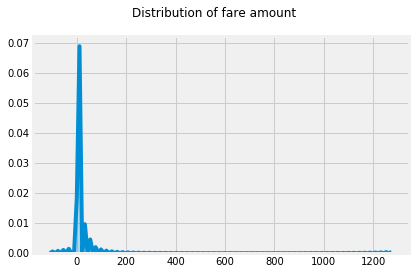

In [10]:
p = sns.kdeplot((df['fare_amount'].values), shade=True)
t = plt.suptitle("Distribution of fare amount")

### Visualizing key bounding co-ordinates in the US - Latitude & Longitude

The following map gives us a good idea of what should be the ideal bounding box latitude and longitude values for the US


![aa](us_lat_long.PNG "US Map depicting Latitude & Longitude")

### Visualizing Distribution of Pickup Co-ordinates in the US

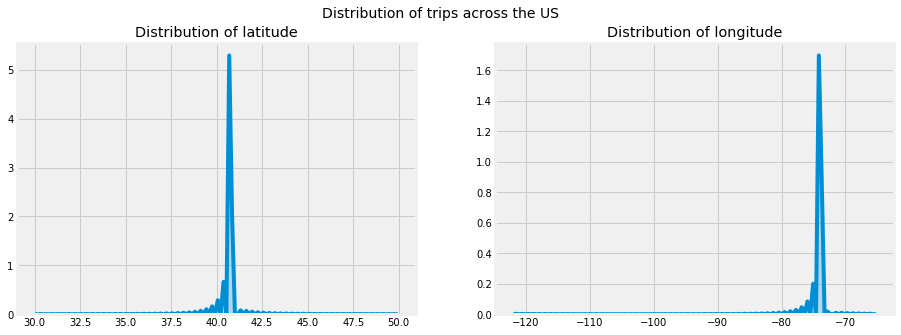

In [11]:
fig = plt.figure(figsize = (14, 5))
title = fig.suptitle("Distribution of trips across the US", fontsize=14)
ax1 = fig.add_subplot(1,2, 1)
p = sns.kdeplot((df[(df['pickup_latitude']>= 30) & (df['pickup_latitude'] <= 50)]['pickup_latitude'].values),
                shade=True,
                ax=ax1)
t= ax1.set_title("Distribution of latitude")

ax2 = fig.add_subplot(1,2, 2)
p = sns.kdeplot((df[(df['pickup_longitude']>= -125) & (df['pickup_longitude'] <= -65)]['pickup_longitude'].values),
                shade=True,
                ax=ax2)
t = ax2.set_title("Distribution of longitude")

### Visualizing distribution of typical passenger counts in trips

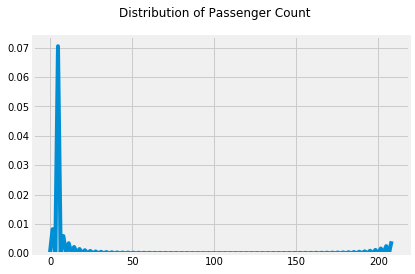

In [12]:
p = sns.kdeplot((df['passenger_count'].values), shade=True)
t= plt.suptitle("Distribution of Passenger Count")

## Fix co-ordinates to be in the US

In [13]:
lat_long = {
    'min_lat':30,
    'max_lat':50,    
    'min_long':-125,
    'max_long':-65, 
}

# Data Wrangling - Outlier Removal

Based on the knowledge from EDA we can focus on removing the following outliers

- Fare amount should be positive and < 1000
- A typical taxi or cab can maybe take at the max 8 people and minimum 1 person 
- Pickup and Dropoff Co-ordinates to be in the US bounding box

In [14]:
bad_filter_cond = (df['fare_amount'].between(0.01, 1000) 
                   & df['passenger_count'].between(1, 8)
                   & df['pickup_latitude'].between(lat_long['min_lat'], lat_long['max_lat'])
                   & df['dropoff_latitude'].between(lat_long['min_lat'], lat_long['max_lat']) 
                   & df['pickup_longitude'].between(lat_long['min_long'], lat_long['max_long'])
                   & df['dropoff_longitude'].between(lat_long['min_long'], lat_long['max_long']))

df = df[bad_filter_cond]

features = df[['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 
               'dropoff_longitude', 'dropoff_latitude', 'passenger_count']]
price = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(features, price, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((6829955, 6), (2927124, 6))

In [15]:
X_train.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
1362371,2011-01-15 18:38:38,-73.99,40.72,-74.01,40.71,1
2606082,2013-06-21 09:44:00,-73.98,40.76,-74.01,40.71,1
1214196,2009-08-05 02:02:04,-73.98,40.77,-73.92,40.77,1
2030088,2009-09-10 11:40:00,-73.96,40.77,-73.96,40.77,1
2275460,2010-06-15 03:30:00,-73.90,40.86,-73.90,40.86,5


# Experiment 2: Baseline Model after Outlier Removal

We rebuild our new baseline model with the raw features after removing the outliers

In [16]:
%%time

xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
xgr.fit(X_train.drop(columns=['pickup_datetime']), y_train)

y_pred = xgr.predict(X_test.drop(columns=['pickup_datetime']))

rsq_baseline2_xgb = r2_score(y_true=y_test, y_pred=y_pred)
adj_rsq_baseline2_xgb = adjusted_r2_score(y_true=y_test, y_pred=y_pred, X_test=X_test)
rmse_baseline2_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred) ** 0.5
print('R-sq:', rsq_baseline2_xgb)
print('Adj. R-sq:', adj_rsq_baseline2_xgb)
print('RMSE:', rmse_baseline2_xgb)

[04:35:54] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
R-sq: 0.7614028324450619
Adj. R-sq: 0.7614023433689486
RMSE: 4.7382390029535735
CPU times: user 21min 18s, sys: 52.3 s, total: 22min 10s
Wall time: 1min 56s


We have __R-sq: 0.76__ and __RMSE: 4.738__ in our new baseline model. 

This is an improvement of __3% R-sq__ and __0.357__ drop in RMSE which is good!

Can we do better than this?

# Experiment 3: Temporal Features from Date and Time

We will leverage the pickup datetime attribute to extract some temporal features which could be useful

- Year
- Month
- Day
- Hour
- Day of the Week

In [17]:
X_train['year'] = X_train['pickup_datetime'].dt.year
X_train['month'] = X_train['pickup_datetime'].dt.month
X_train['day'] = X_train['pickup_datetime'].dt.day
X_train['hour'] = X_train['pickup_datetime'].dt.hour
X_train['day_of_week'] = X_train['pickup_datetime'].dt.weekday


X_test['year'] = X_test['pickup_datetime'].dt.year
X_test['month'] = X_test['pickup_datetime'].dt.month
X_test['day'] = X_test['pickup_datetime'].dt.day
X_test['hour'] = X_test['pickup_datetime'].dt.hour
X_test['day_of_week'] = X_test['pickup_datetime'].dt.weekday

In [18]:
X_train.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week
1362371,2011-01-15 18:38:38,-73.99,40.72,-74.01,40.71,1,2011,1,15,18,5
2606082,2013-06-21 09:44:00,-73.98,40.76,-74.01,40.71,1,2013,6,21,9,4
1214196,2009-08-05 02:02:04,-73.98,40.77,-73.92,40.77,1,2009,8,5,2,2
2030088,2009-09-10 11:40:00,-73.96,40.77,-73.96,40.77,1,2009,9,10,11,3
2275460,2010-06-15 03:30:00,-73.90,40.86,-73.90,40.86,5,2010,6,15,3,1


In [19]:
%%time

xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
xgr.fit(X_train.drop(columns=['pickup_datetime']), y_train)

y_pred = xgr.predict(X_test.drop(columns=['pickup_datetime']))

rsq_temporal_xgb = r2_score(y_true=y_test, y_pred=y_pred)
adj_rsq_temporal_xgb = adjusted_r2_score(y_true=y_test, y_pred=y_pred, X_test=X_test)
rmse_temporal_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred) ** 0.5
print('R-sq:', rsq_temporal_xgb)
print('Adj. R-sq:', adj_rsq_temporal_xgb)
print('RMSE:', rmse_temporal_xgb)

[04:41:16] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
R-sq: 0.7749071377398489
Adj. R-sq: 0.7749062918475548
RMSE: 4.602196769902475
CPU times: user 25min 54s, sys: 52.3 s, total: 26min 46s
Wall time: 2min 1s


We have __R-sq: 0.775__ and __RMSE: 4.602__ in our new model. 

This is an improvement of __1.5% R-sq__ and __0.136__ drop in RMSE which is quite good!

Can we do better than this?

# Experiment 4: Adding Trip Distance as a feature - Haversine Distance

The Earth is round but big, so we can consider it flat for short distances. However, flat-Earth formulas for calculating the distance between two points start showing noticeable errors when the distance is more than about 20 kilometers

Therefore, calculating distances on a sphere needs to consider spherical geometry

The haversine formula is a very accurate way of computing distances between two points on the surface of a sphere using the latitude and longitude of the two points

![](haversine.PNG)

#### Haversine Formula 

The word "Haversine" comes from the function: __haversine(θ) = sin²(θ/2)__

We can further derive the following:

__a = sin²(φB - φA/2) + cos φA * cos φB * sin²(λB - λA/2)__

__c = 2 * atan2( √a, √(1−a) )__

__d = R ⋅ c__

The following equation where,

- __φ is latitude__
- __λ is longitude__
- __R is earth’s radius__ 
- __d is the haversine distance__

Note that angles need to be in radians to pass to trig functions

Source: https://community.esri.com/groups/coordinate-reference-systems/blog/2017/10/05/haversine-formula

In [20]:
from math import radians, cos, sin, asin, sqrt

AVG_EARTH_RADIUS_KM = 6371.0088
AVG_EARTH_RADIUS_MI = 3958.7613

def haversine(start_coord, end_coord, miles=False):
    # get earth radius in required units
    if miles:
        avg_earth_radius = AVG_EARTH_RADIUS_MI
    else:
        avg_earth_radius = AVG_EARTH_RADIUS_KM

    # unpack latitude/longitude
    lat1, lng1 = start_coord
    lat2, lng2 = end_coord

    # convert all latitudes/longitudes from decimal degrees to radians
    lat1, lng1, lat2, lng2 = map(radians, (lat1, lng1, lat2, lng2))

    # calculate haversine
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = sin(lat * 0.5) ** 2 + cos(lat1) * cos(lat2) * sin(lng * 0.5) ** 2
    
    return 2 * avg_earth_radius * asin(sqrt(d))

In [21]:
X_train.drop(columns=['pickup_datetime'], inplace=True)
X_test.drop(columns=['pickup_datetime'], inplace=True)

In [22]:
X_train['haversine_dist'] = X_train.apply(lambda row: haversine(start_coord=(row['pickup_latitude'], 
                                                                             row['pickup_longitude']),
                                                                end_coord=(row['dropoff_latitude'], 
                                                                           row['dropoff_longitude'])), axis=1)

X_test['haversine_dist'] = X_test.apply(lambda row: haversine(start_coord=(row['pickup_latitude'], 
                                                                             row['pickup_longitude']),
                                                                end_coord=(row['dropoff_latitude'], 
                                                                           row['dropoff_longitude'])), axis=1)
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,haversine_dist
1362371,-73.99,40.72,-74.01,40.71,1,2011,1,15,18,5,2.67
2606082,-73.98,40.76,-74.01,40.71,1,2013,6,21,9,4,5.63
1214196,-73.98,40.77,-73.92,40.77,1,2009,8,5,2,2,4.69
2030088,-73.96,40.77,-73.96,40.77,1,2009,9,10,11,3,0.62
2275460,-73.90,40.86,-73.90,40.86,5,2010,6,15,3,1,0.20


In [23]:
%%time

xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

rsq_haversine_xgb = r2_score(y_true=y_test, y_pred=y_pred)
adj_rsq_haversine_xgb = adjusted_r2_score(y_true=y_test, y_pred=y_pred, X_test=X_test)
rmse_haversine_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred) ** 0.5
print('R-sq:', rsq_haversine_xgb)
print('Adj. R-sq:', adj_rsq_haversine_xgb)
print('RMSE:', rmse_haversine_xgb)

[04:51:02] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
R-sq: 0.8302054628656912
Adj. R-sq: 0.8302048247828613
RMSE: 3.9971107177979768
CPU times: user 30min 24s, sys: 58.8 s, total: 31min 23s
Wall time: 2min 26s


We have __R-sq: 0.83__ and __RMSE: 3.997__ in our new model. 

This is an improvement of __5.5% R-sq__ and __0.605__ drop in RMSE which is really excellent!

Can we do better than this?

# Experiment 5: Experimenting with Manhattan Distance as a feature


Based on the gridlike street geography of the New York borough of Manhattan.

The distance between two points measured along axes at right angles. 

![](manhattan.PNG)

In taxicab geometry, the red, yellow, and blue paths all have the same shortest path length of 12.

In a plane with __$p_1$__ at __($x_1, y_1$)__ and __$p_2$__ at __($x_2, y_2$)__,

Manhattan Distance, __M = |$x_1 - x_2$| + |$y_1 - y_2$|__



In [27]:
def manhattan(start_coord, end_coord):
    
    pickup_lat, pickup_long = start_coord
    dropoff_lat, dropoff_long = end_coord    
    distance = np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)
    return distance

In [28]:
X_train['manhattan_dist'] = X_train.apply(lambda row: manhattan(start_coord=(row['pickup_latitude'], 
                                                                             row['pickup_longitude']),
                                                                end_coord=(row['dropoff_latitude'], 
                                                                           row['dropoff_longitude'])), axis=1)

X_test['manhattan_dist'] = X_test.apply(lambda row: manhattan(start_coord=(row['pickup_latitude'], 
                                                                             row['pickup_longitude']),
                                                                end_coord=(row['dropoff_latitude'], 
                                                                           row['dropoff_longitude'])), axis=1)
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,haversine_dist,manhattan_dist
1362371,-73.99,40.72,-74.01,40.71,1,2011,1,15,18,5,2.67,0.04
2606082,-73.98,40.76,-74.01,40.71,1,2013,6,21,9,4,5.63,0.08
1214196,-73.98,40.77,-73.92,40.77,1,2009,8,5,2,2,4.69,0.06
2030088,-73.96,40.77,-73.96,40.77,1,2009,9,10,11,3,0.62,0.01
2275460,-73.90,40.86,-73.90,40.86,5,2010,6,15,3,1,0.20,0.00


In [29]:
%%time

xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
xgr.fit(X_train.drop(columns=['haversine_dist']), y_train)

y_pred = xgr.predict(X_test.drop(columns=['haversine_dist']))

rsq_manhattan_xgb = r2_score(y_true=y_test, y_pred=y_pred)
adj_rsq_manhattan_xgb = adjusted_r2_score(y_true=y_test, y_pred=y_pred, X_test=X_test)
rmse_manhattan_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred) ** 0.5
print('R-sq:', rsq_manhattan_xgb)
print('Adj. R-sq:', adj_rsq_manhattan_xgb)
print('RMSE:', rmse_manhattan_xgb)

[05:04:13] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
R-sq: 0.8223419649870464
Adj. R-sq: 0.8223412366592104
RMSE: 4.088619998818041
CPU times: user 28min 3s, sys: 54.3 s, total: 28min 58s
Wall time: 2min 10s


Our model performance has actually not improved proving haversine distance was a superior feature as compared to manhattan distance here.

### Dropping Manhattan Distance since it didn't yield a better model than Haversine Distance

In [30]:
X_train.drop(columns=['manhattan_dist'], inplace=True)
X_test.drop(columns=['manhattan_dist'], inplace=True)

# Visualizing Pickup and Dropoff Trip Patterns

The idea here is to visualize the pickup and dropoff coordinates of our taxi trips and see if there are any potential interesting patterns which can be used to engineer new features

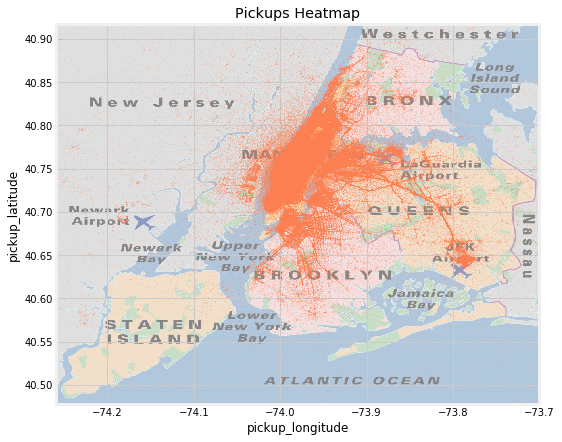

In [31]:
nyc_lat = (40.477399, 40.917577)
nyc_long = (-74.259090, -73.700272)
import matplotlib.image as mpimg
nyc_img = mpimg.imread('nyc_map.png')

ax = df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
        color='coral', s=.05, alpha=.6, figsize=(10,7))
plt.imshow(nyc_img, extent=[nyc_long[0], nyc_long[1], nyc_lat[0], nyc_lat[1]], alpha=0.45)
t = plt.title("Pickups Heatmap")
yl = plt.ylim(nyc_lat)
xl = plt.xlim(nyc_long)

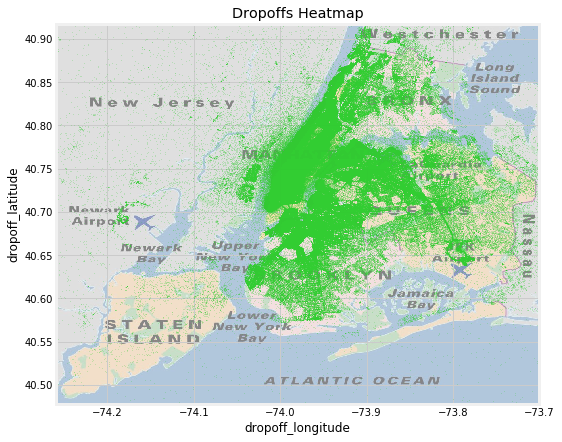

In [32]:
ax = df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
        color='limegreen', s=.05, alpha=.6, figsize=(10,7))
plt.imshow(nyc_img, extent=[nyc_long[0], nyc_long[1], nyc_lat[0], nyc_lat[1]], alpha=0.45)
t = plt.title("Dropoffs Heatmap")
yl = plt.ylim(nyc_lat)
xl = plt.xlim(nyc_long)

An interesting pattern is that a lot of pickups seem to occur at airports and similar patterns with dropoffs. However a lot of dropoffs occur across NYC which is kind of expected.

# Visualizing Airport Trips based on JFK Airport

In [33]:
JFK = {
    'min_lat':40.619,
    'max_lat':40.665,
    'min_lng':-73.835,
    'max_lng':-73.740 
}

JFK_center=[40.642,-73.780]
jfk_pickup_filter = ((df.pickup_latitude >= JFK['min_lat']) 
                      & (df.pickup_latitude <= JFK['max_lat']) 
                      & (df.pickup_longitude >= JFK['min_lng']) 
                      & (df.pickup_longitude <= JFK['max_lng']))
jfk_dropoff_filter = ((df.dropoff_latitude >= JFK['min_lat']) 
                       & (df.dropoff_latitude <= JFK['max_lat']) 
                       & (df.dropoff_longitude >= JFK['min_lng']) 
                       & (df.dropoff_longitude <= JFK['max_lng']))

jfk_pickups = df[jfk_pickup_filter]
jfk_dropoffs = df[jfk_dropoff_filter]
jfk_pickups.iloc[:450].to_csv('jfk_pickups.csv', index=False)
jfk_dropoffs.iloc[:450].to_csv('jfk_dropoffs.csv', index=False)
print('Total pickups from JFK:', jfk_pickups.shape[0])
print('Total dropoffs to JFK:', jfk_dropoffs.shape[0])

Total pickups from JFK: 149740
Total dropoffs to JFK: 75183


In [4]:
import folium

JFK_center=[40.642,-73.780]
m=folium.Map(location =JFK_center, zoom_start = 11,)

for index,row in jfk_pickups.iloc[:450].iterrows():
    pc = [row['pickup_latitude'], row['pickup_longitude']]
    dc = [row['dropoff_latitude'], row['dropoff_longitude']]
    folium.CircleMarker(pc,
                        radius=1, color="red", fill_opacity=0.9).add_to(m)
    folium.CircleMarker(dc,
                        radius=1, color="red", fill_opacity=0.9).add_to(m)
    
    folium.PolyLine(locations=[pc, dc], color='red', smooth_factor=100, weight=0.75, opacity=0.6).add_to(m)

for index,row in jfk_dropoffs.iloc[:450].iterrows():
    pc = [row['pickup_latitude'], row['pickup_longitude']]
    dc = [row['dropoff_latitude'], row['dropoff_longitude']]
    folium.CircleMarker(pc,
                        radius=1, color="limegreen", fill_opacity=0.9).add_to(m)  
    folium.CircleMarker(dc,
                        radius=1, color="red", fill_opacity=0.9).add_to(m)
    folium.PolyLine(locations=[pc, dc], color='limegreen', smooth_factor=100, weight=0.65, opacity=0.25).add_to(m)
    
m.save('nyc_trips.html')

### View interactive map 

This gets reset for some reason when you reload the notebook so you might need to rerun the below cell

In [4]:
from IPython.display import display, HTML, Image

def embed_map(path="map.html"):
    """
    Embeds a linked iframe to the map into the IPython notebook.
    
    Note: this method will not capture the source of the map into the notebook.
    This method should work for all maps (as long as they use relative urls).
    """
    return display(
              HTML('<iframe src="files/{path}" style="width: 100%; height: 510px; border: none"></iframe>'.format(path=path))
    )

# uncomment and run the below line to view the map
#embed_map(path='nyc_trips.html')

### View static map

The same interactive map shown as a static map since it persists even after the notebook is closed

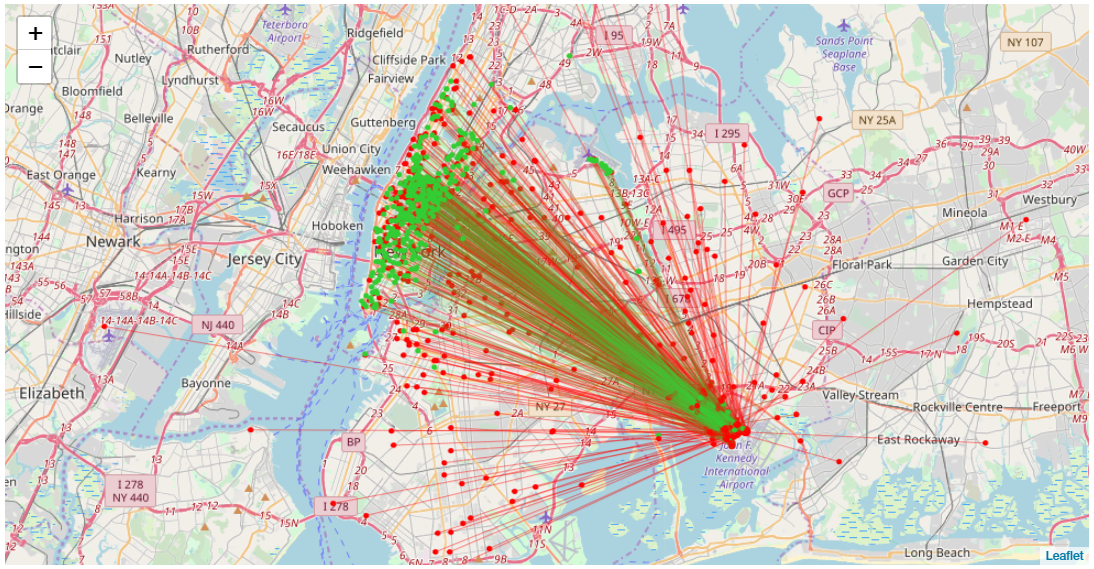

In [6]:
Image(data='jfk_trips_static.PNG')

### Visualizing price differences between airport and non-airport trips 

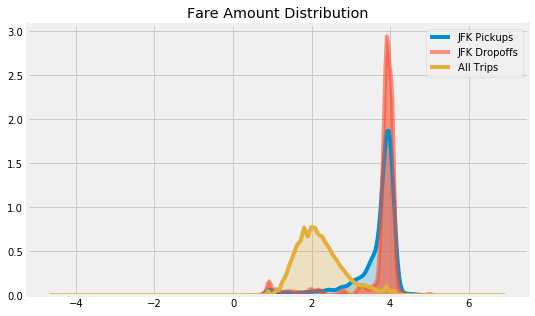

In [37]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(jfk_pickups['fare_amount'].values),label='JFK Pickups', shade=True)
sns.kdeplot(np.log(jfk_dropoffs['fare_amount'].values),label='JFK Dropoffs', shade=True, alpha=0.6)
sns.kdeplot(np.log(df['fare_amount'].values),label='All Trips', shade=True)
t = plt.title("Fare Amount Distribution")

This gives us a good perspective of airport vs. non-airport trips and that we should definitely try and capture some of this using feature engineering.

# Experiment 6: Adding Airport Trips as Features

It's time to add in airport specific trips as features. We will focus on the following key airports in NY\NJ

- Newark Liberty International Airport (EWR)
- LaGuardia Airport (Laguardia)
- John F. Kennedy International Airport (JFK)

The idea is to create a bounding box for these airports and check if the trip pickup or dropoff co-ordinates are inside any of these airport bounding box co-ordinates.

If the above holds good, it is a specific airport trip else not.

In [38]:
nyc_airports = {
    'JFK':{
        'min_lat':40.619,
        'max_lat':40.665,
        'min_lng':-73.835,
        'max_lng':-73.740 
    },
              
    'EWR':{
        'min_lat':40.670, 
        'max_lat':40.709,
        'min_lng':-74.193,
        'max_lng':-74.149
    },
    
    'LaGuardia':{
        'min_lat':40.766, 
        'max_lat':40.786,
        'min_lng':-73.889, 
        'max_lng':-73.855
    }
    
}

def is_airport_trip(latitude, longitude, airport='JFK'):
    
    if (nyc_airports[airport]['min_lat'] <= latitude <= nyc_airports[airport]['max_lat'] 
       and nyc_airports[airport]['min_lng'] <= longitude<=nyc_airports[airport]['max_lng']):
        return 1
    else:
        return 0

In [39]:
#JFK based features
X_train['is_pickup_jfk'] = X_train.apply(lambda row: is_airport_trip(latitude=row['pickup_latitude'], 
                                                                     longitude=row['pickup_longitude'],
                                                                     airport='JFK'),
                                         axis=1)
X_train['is_dropoff_jfk'] = X_train.apply(lambda row: is_airport_trip(latitude=row['dropoff_latitude'],
                                                                      longitude=row['dropoff_longitude'],
                                                                      airport='JFK'),
                                          axis=1)

X_test['is_pickup_jfk'] = X_test.apply(lambda row: is_airport_trip(latitude=row['pickup_latitude'], 
                                                                     longitude=row['pickup_longitude'],
                                                                     airport='JFK'),
                                         axis=1)
X_test['is_dropoff_jfk'] = X_test.apply(lambda row: is_airport_trip(latitude=row['dropoff_latitude'],
                                                                      longitude=row['dropoff_longitude'],
                                                                      airport='JFK'),
                                          axis=1)


# EWR based features
X_train['is_pickup_ewr'] = X_train.apply(lambda row: is_airport_trip(latitude=row['pickup_latitude'], 
                                                                     longitude=row['pickup_longitude'],
                                                                     airport='EWR'),
                                         axis=1)
X_train['is_dropoff_ewr'] = X_train.apply(lambda row: is_airport_trip(latitude=row['dropoff_latitude'],
                                                                      longitude=row['dropoff_longitude'],
                                                                      airport='EWR'),
                                          axis=1)

X_test['is_pickup_ewr'] = X_test.apply(lambda row: is_airport_trip(latitude=row['pickup_latitude'], 
                                                                     longitude=row['pickup_longitude'],
                                                                     airport='EWR'),
                                         axis=1)
X_test['is_dropoff_ewr'] = X_test.apply(lambda row: is_airport_trip(latitude=row['dropoff_latitude'],
                                                                      longitude=row['dropoff_longitude'],
                                                                      airport='EWR'),
                                          axis=1)


# LaGuardia based features
X_train['is_pickup_laguardia'] = X_train.apply(lambda row: is_airport_trip(latitude=row['pickup_latitude'], 
                                                                     longitude=row['pickup_longitude'],
                                                                     airport='LaGuardia'),
                                         axis=1)
X_train['is_dropoff_laguardia'] = X_train.apply(lambda row: is_airport_trip(latitude=row['dropoff_latitude'],
                                                                      longitude=row['dropoff_longitude'],
                                                                      airport='LaGuardia'),
                                          axis=1)

X_test['is_pickup_laguardia'] = X_test.apply(lambda row: is_airport_trip(latitude=row['pickup_latitude'], 
                                                                     longitude=row['pickup_longitude'],
                                                                     airport='LaGuardia'),
                                         axis=1)
X_test['is_dropoff_laguardia'] = X_test.apply(lambda row: is_airport_trip(latitude=row['dropoff_latitude'],
                                                                      longitude=row['dropoff_longitude'],
                                                                      airport='LaGuardia'),
                                          axis=1)

In [40]:
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,haversine_dist,is_pickup_jfk,is_dropoff_jfk,is_pickup_ewr,is_dropoff_ewr,is_pickup_laguardia,is_dropoff_laguardia
1362371,-73.99,40.72,-74.01,40.71,1,2011,1,15,18,5,2.67,0,0,0,0,0,0
2606082,-73.98,40.76,-74.01,40.71,1,2013,6,21,9,4,5.63,0,0,0,0,0,0
1214196,-73.98,40.77,-73.92,40.77,1,2009,8,5,2,2,4.69,0,0,0,0,0,0
2030088,-73.96,40.77,-73.96,40.77,1,2009,9,10,11,3,0.62,0,0,0,0,0,0
2275460,-73.90,40.86,-73.90,40.86,5,2010,6,15,3,1,0.20,0,0,0,0,0,0


In [41]:
%%time

xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

rsq_airports_xgb = r2_score(y_true=y_test, y_pred=y_pred)
adj_rsq_airports_xgb = adjusted_r2_score(y_true=y_test, y_pred=y_pred, X_test=X_test)
rmse_airports_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred) ** 0.5
print('R-sq:', rsq_airports_xgb)
print('Adj. R-sq:', adj_rsq_airports_xgb)
print('RMSE:', rmse_airports_xgb)

[05:35:00] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
R-sq: 0.8308727672029471
Adj. R-sq: 0.8308717849484755
RMSE: 3.9892485239252236
CPU times: user 31min 40s, sys: 1min 3s, total: 32min 43s
Wall time: 2min 24s


We have __R-sq: 0.831__ and __RMSE: 3.989__ in our new model. 

This is an improvement of __0.1% R-sq__ and __0.008__ drop in RMSE.

A minuscule improvement, but even point helps. Is it possible to improve further?

# Visualizing patterns between Fare Amount and Trip Distance

We want to see if trip fare consistently increases with distance or are there any other patterns.

Also are these patterns the same for airport and non-airport trips

In [42]:
airport_trip_filter = ((X_train.is_pickup_jfk == 1) | (X_train.is_dropoff_jfk == 1) 
                       | (X_train.is_pickup_ewr == 1) | (X_train.is_dropoff_ewr == 1)
                       | (X_train.is_pickup_laguardia == 1) | (X_train.is_dropoff_laguardia == 1))

airport_trips = X_train[airport_trip_filter]
nonairport_trips = X_train[~airport_trip_filter]
airport_trips.shape, nonairport_trips.shape

((376750, 17), (6453205, 17))

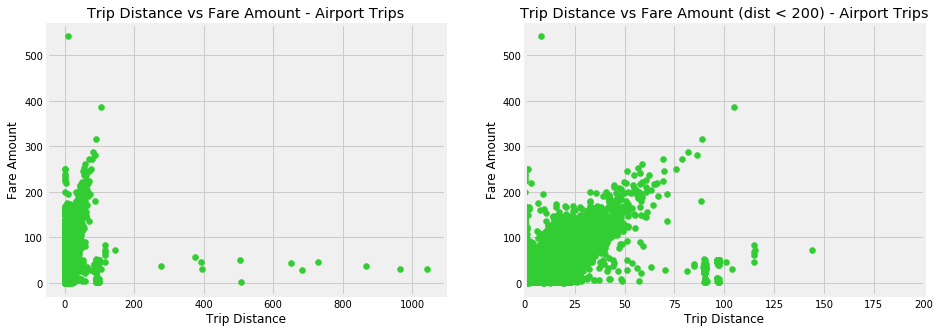

In [43]:
fig = plt.figure(figsize = (14, 5))

ax1 = fig.add_subplot(1,2, 1)
sp = ax1.scatter(x=airport_trips['haversine_dist'],y=y_train[airport_trips.index], color='limegreen')
xl = ax1.set_xlabel("Trip Distance")
yl = ax1.set_ylabel("Fare Amount")
t = ax1.set_title("Trip Distance vs Fare Amount - Airport Trips")

ax2 = fig.add_subplot(1,2, 2)
sp = ax2.scatter(x=airport_trips['haversine_dist'],y=y_train[airport_trips.index], color='limegreen')
ax2.set_xlim([0, 200])
xl = ax2.set_xlabel("Trip Distance")
yl = ax2.set_ylabel("Fare Amount")
t = ax2.set_title("Trip Distance vs Fare Amount (dist < 200) - Airport Trips")

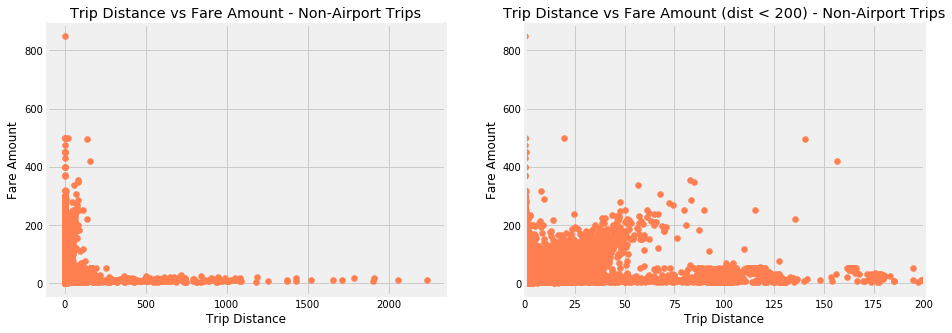

In [44]:
fig = plt.figure(figsize = (14, 5))

ax1 = fig.add_subplot(1,2, 1)
sp = ax1.scatter(x=nonairport_trips['haversine_dist'],y=y_train[nonairport_trips.index], color='coral')
xl = ax1.set_xlabel("Trip Distance")
yl = ax1.set_ylabel("Fare Amount")
t = ax1.set_title("Trip Distance vs Fare Amount - Non-Airport Trips")

ax2 = fig.add_subplot(1,2, 2)
sp = ax2.scatter(x=nonairport_trips['haversine_dist'],y=y_train[nonairport_trips.index], color='coral')
ax2.set_xlim([0, 200])
xl = ax2.set_xlabel("Trip Distance")
yl = ax2.set_ylabel("Fare Amount")
t = ax2.set_title("Trip Distance vs Fare Amount (dist < 200) - Non-Airport Trips")

Looks like regular trips have a distance of < 80 for airport trips and < 60 for non-airport trips where fare has a strong positive correlation with distance.

For trips greater than this distance, looks like they might have a fixed fee (or could be potential outliers)

# Experiment 7: Experimenting with Long and Short Trips as a Feature

Based on the previous analysis, we engineer a new feature to identify if a trip is a regular or a long trip

In [45]:
def is_long_trip(record):
    if ((record.is_pickup_jfk == 1) | (record.is_dropoff_jfk == 1) 
         | (record.is_pickup_ewr == 1) | (record.is_dropoff_ewr == 1)
         | (record.is_pickup_laguardia == 1) | (record.is_dropoff_laguardia == 1)):
        airport_trip = True
    else:
        airport_trip = False
        
    if is_airport_trip:
        if record.haversine_dist >= 80:
            return 1
        else:
            return 0
    else:
        if record.haversine_dist >= 60:
            return 1
        else:
            return 0

In [46]:
X_train['is_long_trip'] = X_train.apply(lambda row: is_long_trip(row), axis=1)
X_test['is_long_trip'] = X_test.apply(lambda row: is_long_trip(row), axis=1)

In [47]:
X_test['is_long_trip'].value_counts()

0    2926014
1       1110
Name: is_long_trip, dtype: int64

In [48]:
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,haversine_dist,is_pickup_jfk,is_dropoff_jfk,is_pickup_ewr,is_dropoff_ewr,is_pickup_laguardia,is_dropoff_laguardia,is_long_trip
1362371,-73.99,40.72,-74.01,40.71,1,2011,1,15,18,5,2.67,0,0,0,0,0,0,0
2606082,-73.98,40.76,-74.01,40.71,1,2013,6,21,9,4,5.63,0,0,0,0,0,0,0
1214196,-73.98,40.77,-73.92,40.77,1,2009,8,5,2,2,4.69,0,0,0,0,0,0,0
2030088,-73.96,40.77,-73.96,40.77,1,2009,9,10,11,3,0.62,0,0,0,0,0,0,0
2275460,-73.90,40.86,-73.90,40.86,5,2010,6,15,3,1,0.20,0,0,0,0,0,0,0


In [49]:
%%time

xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

rsq_trip_len_xgb = r2_score(y_true=y_test, y_pred=y_pred)
adj_rsq_trip_len_xgb = adjusted_r2_score(y_true=y_test, y_pred=y_pred, X_test=X_test)
rmse_trip_len_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred) ** 0.5
print('R-sq:', rsq_trip_len_xgb)
print('Adj. R-sq:', adj_rsq_trip_len_xgb)
print('RMSE:', rmse_trip_len_xgb)

[05:57:21] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
R-sq: 0.8308727672029471
Adj. R-sq: 0.8308717271684454
RMSE: 3.9892485239252236
CPU times: user 32min 2s, sys: 1min 3s, total: 33min 5s
Wall time: 2min 25s


There is no marked improvement in the model performance and this is expected considering the number of long trips are far too less as compared to rest of the data points. 

Also several of them could be potential outliers considering they may not even be trips inside NYC and we might consider removing them in the future.

# Experiment 8: Adding Borough based trips as features

![](nyc_boroughs.PNG)

There are a total of five boroughs in New York City

The term borough was adopted to describe a form of governmental administration for each of the five fundamental constituent parts of NYC

The idea is that trips to and from different boroughs might have different pricing patterns

In [50]:
nyc_boroughs={
    'manhattan':{
        'min_lng':-74.047,
        'min_lat':40.682,
        'max_lng':-73.906,
        'max_lat':40.882
    },
    
    'queens':{
        'min_lng':-73.963,
        'min_lat':40.543,
        'max_lng':-73.700,
        'max_lat':40.800

    },

    'brooklyn':{
        'min_lng':-74.042,
        'min_lat':40.570,
        'max_lng':-73.833,
        'max_lat':40.739

    },

    'bronx':{
        'min_lng':-73.933,
        'min_lat':40.785,
        'max_lng':-73.765,
        'max_lat':40.917

    },

    'staten_island':{
        'min_lng':-74.255,
        'min_lat':40.496,
        'max_lng':-74.052,
        'max_lat':40.649

    }
    
}


def get_borough_name(lat,lng):
    
    locs=nyc_boroughs.keys()
    for loc in locs:
        if (lat>=nyc_boroughs[loc]['min_lat'] 
           and lat<=nyc_boroughs[loc]['max_lat'] 
           and lng>=nyc_boroughs[loc]['min_lng'] 
           and lng<=nyc_boroughs[loc]['max_lng']):
            return loc
    return 'others'

In [51]:
X_train['pickup_borough'] = X_train.apply(lambda row: get_borough_name(row['pickup_latitude'],row['pickup_longitude']),axis=1)
X_train['dropoff_borough'] = X_train.apply(lambda row: get_borough_name(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

X_test['pickup_borough'] = X_test.apply(lambda row: get_borough_name(row['pickup_latitude'],row['pickup_longitude']),axis=1)
X_test['dropoff_borough'] = X_test.apply(lambda row: get_borough_name(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

In [52]:
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,haversine_dist,is_pickup_jfk,is_dropoff_jfk,is_pickup_ewr,is_dropoff_ewr,is_pickup_laguardia,is_dropoff_laguardia,is_long_trip,pickup_borough,dropoff_borough
1362371,-73.99,40.72,-74.01,40.71,1,2011,1,15,18,5,2.67,0,0,0,0,0,0,0,manhattan,manhattan
2606082,-73.98,40.76,-74.01,40.71,1,2013,6,21,9,4,5.63,0,0,0,0,0,0,0,manhattan,manhattan
1214196,-73.98,40.77,-73.92,40.77,1,2009,8,5,2,2,4.69,0,0,0,0,0,0,0,manhattan,manhattan
2030088,-73.96,40.77,-73.96,40.77,1,2009,9,10,11,3,0.62,0,0,0,0,0,0,0,manhattan,manhattan
2275460,-73.90,40.86,-73.90,40.86,5,2010,6,15,3,1,0.20,0,0,0,0,0,0,0,bronx,bronx


Based on these categorical features we obtained, we can leverage label encoding or one-hot encoding and build our models. Let's try both!

# Experiment 8A: Label-Encoding Borough Trip Features

Tree-based models natively can actually handle categorical variables without the need to often explicitely one-hot encode them as opposed to other models (especially parametric ones).

Let's engineer these features as label encoded features and build our model

In [59]:
X_train_le = X_train.copy(deep=True)
X_train_le['pickup_borough'] = X_train['pickup_borough'].astype('category').cat.codes
X_train_le['dropoff_borough'] = X_train['dropoff_borough'].astype('category').cat.codes

X_test_le = X_test.copy(deep=True)
X_test_le['pickup_borough'] = X_test['pickup_borough'].astype('category').cat.codes
X_test_le['dropoff_borough'] = X_test['dropoff_borough'].astype('category').cat.codes

In [60]:
X_train_le.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,haversine_dist,is_pickup_jfk,is_dropoff_jfk,is_pickup_ewr,is_dropoff_ewr,is_pickup_laguardia,is_dropoff_laguardia,is_long_trip,pickup_borough,dropoff_borough
1362371,-73.99,40.72,-74.01,40.71,1,2011,1,15,18,5,2.67,0,0,0,0,0,0,0,2,2
2606082,-73.98,40.76,-74.01,40.71,1,2013,6,21,9,4,5.63,0,0,0,0,0,0,0,2,2
1214196,-73.98,40.77,-73.92,40.77,1,2009,8,5,2,2,4.69,0,0,0,0,0,0,0,2,2
2030088,-73.96,40.77,-73.96,40.77,1,2009,9,10,11,3,0.62,0,0,0,0,0,0,0,2,2
2275460,-73.90,40.86,-73.90,40.86,5,2010,6,15,3,1,0.20,0,0,0,0,0,0,0,0,0


In [66]:
%%time

xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
xgr.fit(X_train_le, y_train)

y_pred = xgr.predict(X_test_le)

rsq_borough_xgb = r2_score(y_true=y_test, y_pred=y_pred)
adj_rsq_borough_xgb = adjusted_r2_score(y_true=y_test, y_pred=y_pred, X_test=X_test_le)
rmse_borough_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred) ** 0.5
print('R-sq:', rsq_borough_xgb)
print('Adj. R-sq:', adj_rsq_borough_xgb)
print('RMSE:', rmse_borough_xgb)

[06:24:05] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
R-sq: 0.830870163254247
Adj. R-sq: 0.8308690076417746
RMSE: 3.9892792338184604
CPU times: user 33min 8s, sys: 1min 1s, total: 34min 9s
Wall time: 2min 28s


Looks like these features are not having any effect on our model! This could be because there are other more dominant features which are selected as important features given that we are using a tree-based ensemble model following boosting priciples. 

Also the max-depth of each tree is 5 which can be a reason for these features not getting selected at all!

Let's try one-hot encoding now!

# Experiment 8B: One-hot Encoding Borough Trip Features

Now it is time to apply one-hot encoding to our borough features. In one-hot encoding, if you have __n__ different categories in a categorical feature, you end up with __n__ columns depicting each distinct category as a binary feature (present or absent)

In [67]:
X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)

In [68]:
X_train_ohe.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,...,pickup_borough_manhattan,pickup_borough_others,pickup_borough_queens,pickup_borough_staten_island,dropoff_borough_bronx,dropoff_borough_brooklyn,dropoff_borough_manhattan,dropoff_borough_others,dropoff_borough_queens,dropoff_borough_staten_island
1362371,-73.99,40.72,-74.01,40.71,1,2011,1,15,18,5,...,1,0,0,0,0,0,1,0,0,0
2606082,-73.98,40.76,-74.01,40.71,1,2013,6,21,9,4,...,1,0,0,0,0,0,1,0,0,0
1214196,-73.98,40.77,-73.92,40.77,1,2009,8,5,2,2,...,1,0,0,0,0,0,1,0,0,0
2030088,-73.96,40.77,-73.96,40.77,1,2009,9,10,11,3,...,1,0,0,0,0,0,1,0,0,0
2275460,-73.90,40.86,-73.90,40.86,5,2010,6,15,3,1,...,0,0,0,0,1,0,0,0,0,0


In [69]:
%%time

xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
xgr.fit(X_train_ohe, y_train)

y_pred = xgr.predict(X_test_ohe)

rsq_borough_xgb = r2_score(y_true=y_test, y_pred=y_pred)
adj_rsq_borough_xgb = adjusted_r2_score(y_true=y_test, y_pred=y_pred, X_test=X_test_ohe)
rmse_borough_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred) ** 0.5
print('R-sq:', rsq_borough_xgb)
print('Adj. R-sq:', adj_rsq_borough_xgb)
print('RMSE:', rmse_borough_xgb)

[06:27:55] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
R-sq: 0.8319666475341864
Adj. R-sq: 0.831964925347507
RMSE: 3.9763267746808784
CPU times: user 36min 35s, sys: 1min 7s, total: 37min 42s
Wall time: 2min 40s


We have __R-sq: 0.832__ and __RMSE: 3.976__ in our new model. 

This is an improvement of __0.1% R-sq__ and __0.013__ drop in RMSE.

A minuscule improvement. Maybe increasing the depth of the trees and more trees might help in this aspect?

# Training a full-fledged XGBoost Model on the final featureset

The intent here is to not really tune the model but see if more trees with a larger max depth help in improving the model.

We recommend leveraging cross-validation always for tuning and to __never__ ever tune on the test dataset

In [35]:
%%time

xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=1000, max_depth=10, n_jobs=-1, random_state=42)
xgr.fit(X_train_ohe, y_train)

y_pred = xgr.predict(X_test_ohe)

rsq_final_xgb = r2_score(y_true=y_test, y_pred=y_pred)
adj_rsq_final_xgb = adjusted_r2_score(y_true=y_test, y_pred=y_pred, X_test=X_test_ohe)
rmse_final_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred) ** 0.5
print('R-sq:', rsq_final_xgb)
print('Adj. R-sq:', adj_rsq_final_xgb)
print('RMSE:', rmse_final_xgb)

[11:57:53] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
R-sq: 0.8658962679927098
Adj. R-sq: 0.8658948935533052
RMSE: 3.5522600653055423
CPU times: user 2d 23h 34min 44s, sys: 2h 45min 53s, total: 3d 2h 20min 38s
Wall time: 5h 16min 39s


A nice jump in the __R-sq__ by __3.3%__ to give us a final score of __86.5%__

__RMSE__ also drops by __0.424__ to give a final score of __3.552__

# Future Scope

Try experimenting with time based features like taking into account seasonality, drill down into specific boroughs for more patterns with regard to trips, distances. Maybe even tourist points like Statue of Liberty? Focus only on NYC based data points instead of complete US. Add in more data points to train!